In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import ulfy
from dolfin import *
from tabulate import tabulate

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


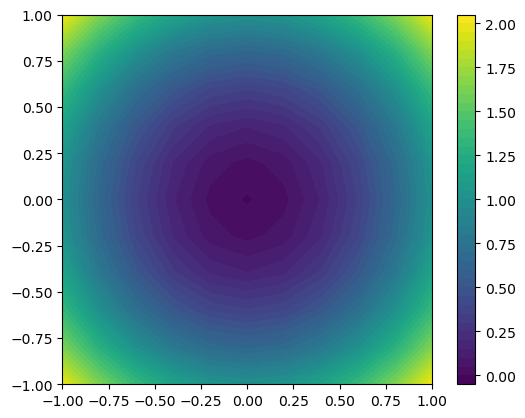

In [19]:
# Define unit normaal vector of boudnaries.
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}


# Define various subdomains.
subdomains = {1: CompiledSubDomain('near(x[0], -1)'),
              2: CompiledSubDomain('near(x[0], 1)'),
              3: CompiledSubDomain('near(x[1], -1)'),
              4: CompiledSubDomain('near(x[1], 1)')}


N = 10
# Define MMS Place holders
mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)


x, y = SpatialCoordinate(mesh)
# Prepare coefficients
a = 1.0
K = 1.0
gamma = 1.0
alpha = 2.0

# Define solution.
p = a * (x**2 + y**2)
f = -K * div(grad(p))
gR = {tag: alpha * p + K* inner(grad(p), n) for tag, n in normals.items()}


# Define functionspace etc.
V = FunctionSpace(mesh, "CG", 1)
boundaries = MeshFunction('size_t', mesh, 1, 0)
[subd.mark(boundaries, tag) for tag, subd in subdomains.items()]

u = TrialFunction(V)
v = TestFunction(V)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

F = K * inner(grad(u), grad(v)) * dx  # LHS
F -= f * v * dx  # Strong form of MMS
F += sum([(alpha * u - gR[tag]) * v * ds(tag) for tag in gR])


a = lhs(F)
L = rhs(F)
A = assemble(a)
b = assemble(L)
ph = Function(V)
solve(A, ph.vector(), b)

c = plot(ph)
plt.colorbar(c)